# Лекция №11

## На прошлой лекции

[Нелинейный источник. ODE](#ODE)

[Граничные условия](#bc)

[Уравнения Эйлера. rhoCentralFoam](#Euler)

## План
1. [Термодинамика OpenFOAM](#thermo)
2. [Метод Годунова](#godunov)
3. [Задачи Сода](#Sod)
4. [Задача Риммана о распаде произвольного разрыва](#riemman)
5. [OpenFOAM sod](#of_sod)

## Термодинамика OpenFOAM <a name="thermo"></a>

$${{ \partial \rho}  \over  { \partial t} } + {  { \partial (\rho U )}  \over  { \partial x} } =0 \\
{{ \partial \rho U}  \over  { \partial t} } + {  { \partial (\rho U^2 + p )}  \over  { \partial x} } =0 \\
{{ \partial E}  \over  { \partial t} } + {  { \partial (\rho U H )}  \over  { \partial x} } =0 \\
E = \rho (e + U^2/2) \\
H = (E+p)/\rho
$$

Из термодинамики: равновесную систему можно описать любыми двумя параметрами (остальные функционально зависимы)

Стандартно использовать переменные $\rho$ и $e$ в качестве основных + система замыкается $p = p(\rho, e)$ и $\gamma = \gamma (\rho, e)$

Для химически неравновесной системы (учет химических реакций) в качестве основных используются переменные $p$ и $T$

В OpenFOAM свой путь! Изначально библиотека для несжимаемых течений. Pressure-based идеалогия. Сложности для сверхзвуковых (сжимаемых) задач.

$M = U/a$ или отношение конвективного слагаемого к градиенту давления

0 < $M$ < 0.7 - несжимаемые течения (система уравнений эллиптического типа)

0.7 < $M$ < 1.2 - трансзвуковые течения (слабая сжимаемости ($\rho \neq const$), неустойчивость M=1)

1.2 < $M$ < 5 - сверхзвуковые течения (учет сжимаемости, скачки уплотнения)

$M$ > 5  - гиперзвуковые течения (+сильно нелинейная термодинамика, химические реакции)

$M$ > 25  - спускаемые аппараты (+излучение)

In [ ]:
#!cat $WM_PROJECT_DIR/applications/solvers/compressible/rhoCentralFoam/rhoCentralFoam.C

```c++
/*---------------------------------------------------------------------------*\
  =========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     |
    \\  /    A nd           | www.openfoam.com
     \\/     M anipulation  |
-------------------------------------------------------------------------------
    Copyright (C) 2011-2016 OpenFOAM Foundation
-------------------------------------------------------------------------------
License
    This file is part of OpenFOAM.

    OpenFOAM is free software: you can redistribute it and/or modify it
    under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    OpenFOAM is distributed in the hope that it will be useful, but WITHOUT
    ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License
    for more details.

    You should have received a copy of the GNU General Public License
    along with OpenFOAM.  If not, see <http://www.gnu.org/licenses/>.

Application
    rhoCentralFoam

Group
    grpCompressibleSolvers

Description
    Density-based compressible flow solver based on central-upwind
    schemes of Kurganov and Tadmor.

\*---------------------------------------------------------------------------*/

#include "fvCFD.H"
#include "psiThermo.H"
#include "turbulentFluidThermoModel.H"
#include "fixedRhoFvPatchScalarField.H"
#include "directionInterpolate.H"
#include "localEulerDdtScheme.H"
#include "fvcSmooth.H"

// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

int main(int argc, char *argv[])
{
    argList::addNote
    (
        "Density-based compressible flow solver based on central-upwind"
        " schemes of Kurganov and Tadmor."
    );

    #define NO_CONTROL
    #include "postProcess.H"

    #include "addCheckCaseOptions.H"
    #include "setRootCaseLists.H"
    #include "createTime.H"
    #include "createMesh.H"
    #include "createFields.H"
    #include "createFieldRefs.H"
    
    ...

    return 0;
}

// ************************************************************************* //
```

In [ ]:
#!cat $WM_PROJECT_DIR/applications/solvers/compressible/rhoCentralFoam/createFields.H

[createRDeltaT.H doxygen](https://www.openfoam.com/documentation/guides/latest/api/createRDeltaT_8H_source.html)

```c++
#include "createRDeltaT.H"

Info<< "Reading thermophysical properties\n" << endl;

autoPtr<psiThermo> pThermo
(
    psiThermo::New(mesh)
);
psiThermo& thermo = pThermo();

volScalarField& e = thermo.he();

...
```

In [ ]:
#!cat $WM_PROJECT_DIR/applications/solvers/compressible/rhoCentralFoam/createFieldRefs.H

```c++
volScalarField& p = thermo.p();
const volScalarField& T = thermo.T();
const volScalarField& psi = thermo.psi();
const volScalarField& mu = thermo.mu();

bool inviscid(true);
if (max(mu.primitiveField()) > 0.0)
{
    inviscid = false;
}
```

In [1]:
ls thermo/shockTube/constant

polyMesh/  thermophysicalProperties  turbulenceProperties


In [ ]:
#!cat thermo/shockTube/constant/thermophysicalProperties

```c++
/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "constant";
    object      thermophysicalProperties;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

thermoType
{
    type            a;//hePsiThermo;
    mixture         pureMixture;
    transport       const;
    thermo          hConst;
    equationOfState perfectGas;
    specie          specie;
    energy          sensibleInternalEnergy;
}

mixture
{
    specie
    {
        molWeight       28.96;
    }
    thermodynamics
    {
        Cp              1004.5;
        Hf              2.544e+06;
    }
    transport
    {
        mu              0;
        Pr              1;
    }
}


// ************************************************************************* //
```

In [2]:
!rhoCentralFoam -case thermo/shockTube/

/*---------------------------------------------------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
Build  : _7bdb509494-20201222 OPENFOAM=2012
Arch   : "LSB;label=32;scalar=64"
Exec   : rhoCentralFoam -case thermo/shockTube/
Date   : Dec 07 2021
Time   : 15:20:03
Host   : kuvv-PS63-Modern-8M
PID    : 92766
I/O    : uncollated
Case   : /home/kuvv/work/Projects/phystech_lectures/lecture_12/thermo/shockTube
nProcs : 1
trapFpe: Floating point exception trapping enabled (FOAM_SIGFPE).
fileModificationChecking : Monitoring run-time modifie

[thremophysical model OpenFOAM](https://www.openfoam.com/documentation/user-guide/5-models-and-physical-properties/5.2-thermophysical-models)

In [3]:
ls $WM_PROJECT_DIR/src/thermophysicalModels

Allwmake*                        SLGThermo/
barotropicCompressibilityModel/  solidChemistryModel/
basic/                           solidSpecie/
chemistryModel/                  solidThermo/
doc/                             specie/
laminarFlameSpeed/               thermophysicalProperties/
radiation/                       thermophysicalPropertiesFvPatchFields/
reactionThermo/


In [4]:
ls $WM_PROJECT_DIR/src/thermophysicalModels/specie

atomicWeights/    include/    reaction/       speciesTable/
doc/              lnInclude/  specie/         thermo/
equationOfState/  Make/       specieElement/  transport/


In [5]:
ls $WM_PROJECT_DIR/src/thermophysicalModels/specie/equationOfState

adiabaticPerfectFluid/  incompressiblePerfectGas/  perfectGas/
Boussinesq/             linear/                    rhoConst/
icoPolynomial/          PengRobinsonGas/           rPolynomial/
icoTabulated/           perfectFluid/


[perfectGas](https://www.openfoam.com/documentation/guides/latest/api/perfectGasI_8H_source.html)

[PengRobinsonGas](https://www.openfoam.com/documentation/guides/latest/api/PengRobinsonGasI_8H_source.html)

In [6]:
ls $WM_PROJECT_DIR/src/thermophysicalModels/specie/transport

const/  logPolynomial/  polynomial/  sutherland/  tabulated/  WLF/


[sutherland](https://www.openfoam.com/documentation/guides/latest/api/sutherlandTransportI_8H_source.html)

In [7]:
ls $WM_PROJECT_DIR/src/thermophysicalModels/specie/thermo

absoluteEnthalpy/        hPolynomial/  sensibleEnthalpy/
absoluteInternalEnergy/  hPower/       sensibleInternalEnergy/
eConst/                  hTabulated/   thermo/
hConst/                  janaf/


[janaf](https://www.openfoam.com/documentation/guides/latest/api/janafThermoI_8H_source.html)

[hePsiThermo](https://www.openfoam.com/documentation/guides/latest/api/hePsiThermo_8C_source.html) - thermo.correct()

[THE](https://www.openfoam.com/documentation/guides/latest/api/thermoI_8H_source.html#l00346)

## Метод Годунова <a name="godunov"></a>

[Toro](../books/toro.pdf) p.165 (144)

[Куликовский Погорелов Семенов](../books/kul.pdf) p.242

[Blazek](../books/blazek.pdf) p 104 (95)

Шлирен фотография внешнего обтекания сферы сверхзвуковым потоком воздуха
<img src="img/sphere.jpg" width="800" height="200">

Проблема с разрывными решениями. Выделением головного скачка уплотнения (ударная волна - граница).

Метод Годунова (контрольного объема). Метод сквозного счета (на любой сетке - УВ) г.1959. До сих пор весь мир использует.

$${{ \partial \rho}  \over  { \partial t} } + {  { \partial (\rho U )}  \over  { \partial x} } =0 \\
{{ \partial \rho U}  \over  { \partial t} } + {  { \partial (\rho U^2 + p )}  \over  { \partial x} } =0 \\
{{ \partial E}  \over  { \partial t} } + {  { \partial (\rho U H )}  \over  { \partial x} } =0 
$$

КАК НАЙТИ $\vec F$ на грани?

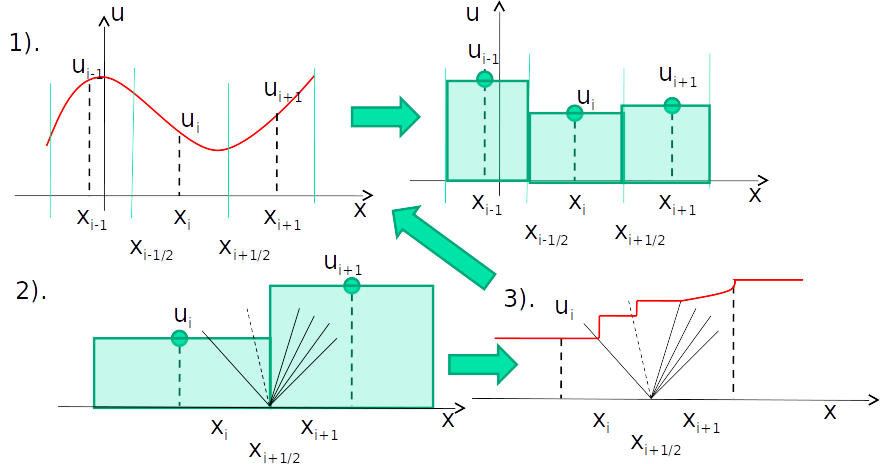

Газодинамика. Метод контрольного объема с физической интерпретацией расчета потоков на гранях. Одномерная труба с перегородкой. Решение на грани - решение одномерной задачи. (Схема Годунова).

Плюсы - точное решение

Минусы - итерационный прожерливый процесс расчета

Для увеличения порядка аппроксимации используется линейное распределение в ячейках (значение в центре + градиент*лимитер! TVD)

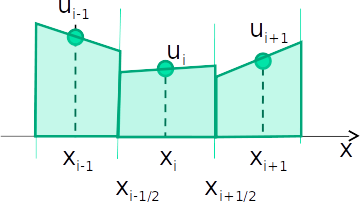

## Задачи Сода <a name="Sod"></a>

Для уравнений газовой динамики (Эйлера) всего 5 характерных случаев решения задачи произвольного разрыва в зависимости от условий справа и слева.

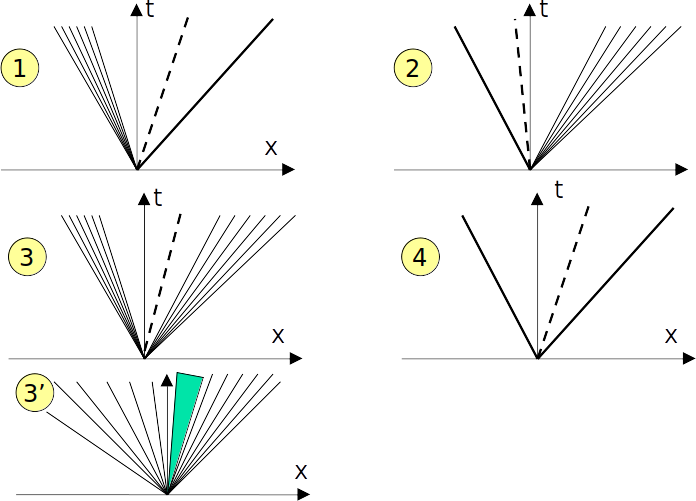

Автомодельное решение относительно $x/t$, существует точное аналитическое решение. Тестовые задачи для всех схем! 

[Задачи Сода (случаи)](../books/toro.pdf) p  316 (296)

[Задачи Сода (НУ)](../books/toro.pdf) p  300 (280)

## Задача Риммана (распад произвольного разрыва) <a name="riemman"></a>

$${\partial{\vec u}\over {\partial t}}+{\partial{\vec f(\vec u)}\over {\partial x}}=0 \\
-\infty < x < \infty , t> 0 \\
u(x,t = 0) = u^0(x) = \begin{cases}
    u_L, x<0      \\
    u_R, x>0
  \end{cases}$$

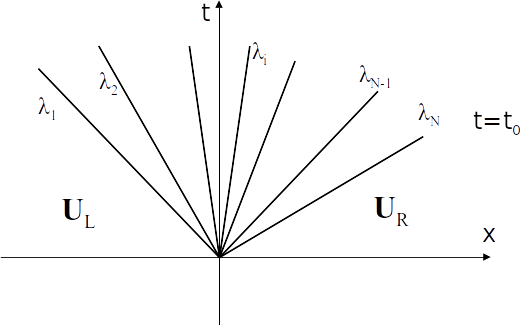

Схема Годунова использует итерационный процесс, долго работает, необходимо решать на каждой грани на каждой итерации.
Какой смысл точно и долго решать задачу, когда она все равно часть приближенного общего численного алгоритма?

Может быть есть линейные (менее точные, но быстрые) схемы для решения данной задачи? Есть, их много, очень много!

[Схема Годунова](../books/toro.pdf) p 313 (294)

[Flux vector splitting (FVS) method](../books/toro.pdf) p 285 (265)

Схема КИР (Куранта Изаксона Риса): ${u_i^{n+1} - u_i^n \over \Delta t}  + (|a|+a)/2{u_i^n - u_{i-1}^n \over \Delta x} + (|a|-a)/2{u_{i+1}^n - u_{i}^n \over \Delta x} = 0$

или ${u_i^{n+1} - u_i^n \over \Delta t} \Delta x  + (|a|+a)/2(u_i^n - u_{i-1}^n ) + (|a|-a)/2(u_{i+1}^n - u_{i}^n ) = 0$

или если $f_{i+1/2} = au_{i+1/2} = {a \over 2}(u_{i+1}+u_{i})- {|a| \over 2}(u_{i+1} - u_{i})$

то ${u_i^{n+1} - u_i^n \over \Delta t} \Delta x + f_{i+1/2}^n-f_{i-1/2}^n = 0$

В зависимости от знака $a$ - "правый" или "левый" уголок

или значение для поток справа или слева

[Steger-Warming scheme](../books/toro.pdf) p 296 (276)

[vanLeer scheme](../books/toro.pdf) p 297 (277)

[AUSM - Advection Upstream Splitting Method (Liou, M.-S. and Steffen, C) wiki](https://en.wikipedia.org/wiki/AUSM)

[AUSM](../books/toro.pdf) p 298 (278)

Flux-difference splitting scheme

На поверхности разрыва условия Ренкина-Гюгонио:

$$f(u_R) - f(u_L) = S(u_R-u_L)$$

где $S$ - скорость распространения разрыва, $u_R, u_L$ - состояния слева и справа от него

[Roe scheme](../books/blazek.pdf) p 112 (103)

[Roe wiki](https://en.wikipedia.org/wiki/Roe_solver)

[HLL - Harten, Lax, van Leer](../books/toro.pdf) p 338 (320)

[HLLE - Harten, Lax, van Leer](../books/toro.pdf) p 338 (320) = HLL + Roe осреднение

[HLLC - Harten, Lax, van Leer + contact (Toro)](../books/toro.pdf) p 340 (322)





Характерные свойства схем:
Steger-Warming, HLL, HLLE: 
* диссипативные схемы (размазывают контактный разрыв)
* хорошо для решения в области головного скачка
* плохо для решения в пограничном слое! 
* при низком порядке аппроксимации (upwind) почти невозможно получить правильное решение в области ПС 

Roe
* слабодиссипативная схема
* используется энтропийная коррекция (иначе разваливается) в задачах с сильным головным скачком
* отлично разрешает пограничный слой
* основная сфера применения - струйные течения (изоэнтропические, без сильных скачков уплотнения)

HLLC, AUSM, AUSM+, AUSM+Up ...
* самые универсальные схемы с низкой диссипацией и стабильным разрешением сильных скачков
* применяются для решения различных гиперболических уравнений (не только газодинамика)
* свои подводные камни (карбункул эффект у всех низкодиссипативных схем)

## OpenFOAM sod <a name="of_sod"></a>

Пример: tutorials/compressible/rhoCentralFoam/shockTube/

In [8]:
ls sod

p.png  rho.png  shockTube_1ord/  shockTube_2ord/  T.png  U.png


In [9]:
!cat sod/shockTube_1ord/constant/thermophysicalProperties

/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "constant";
    object      thermophysicalProperties;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

thermoType
{
    type            hePsiThermo;
    mixture         pureMixture;
    transport       const;
    thermo          hConst;
    equationOfState perfectGas;
    specie          specie;
    energy

In [10]:
!cat sod/shockTube_1ord/system/fvSchemes

/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "system";
    object      fvSchemes;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

fluxScheme      Kurganov;

ddtSchemes
{
    default         Euler;
}

gradSchemes
{
    default         Gauss linear;
}

divSchemes
{
    default         none;
    div(tauMC)      Gauss linear;
}

laplacianSchemes
{
    d

In [11]:
!cat sod/shockTube_2ord/system/fvSchemes

/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "system";
    object      fvSchemes;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

fluxScheme      Kurganov;

ddtSchemes
{
    default         Euler;
}

gradSchemes
{
    default         Gauss linear;
}

divSchemes
{
    default         none;
    div(tauMC)      Gauss linear;
}

laplacianSchemes
{
    d

In [12]:
!cat sod/shockTube_1ord/system/setFieldsDict

/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "system";
    object      setFieldsDict;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

defaultFieldValues
(
    volVectorFieldValue U (0 0 0)
    volScalarFieldValue T 348.432
    volScalarFieldValue p 100000
);

regions
(
    boxToCell
    {
        box (0 -1 -1) (5 1 1);
        fieldValues
        (


In [13]:
!rhoCentralFoam -case sod/shockTube_1ord/

/*---------------------------------------------------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
Build  : _7bdb509494-20201222 OPENFOAM=2012
Arch   : "LSB;label=32;scalar=64"
Exec   : rhoCentralFoam -case sod/shockTube_1ord/
Date   : Dec 07 2021
Time   : 16:10:35
Host   : kuvv-PS63-Modern-8M
PID    : 109348
I/O    : uncollated
Case   : /home/kuvv/work/Projects/phystech_lectures/lecture_12/sod/shockTube_1ord
nProcs : 1
trapFpe: Floating point exception trapping enabled (FOAM_SIGFPE).
fileModificationChecking : Monitoring run-time mo

Mean and max Courant Numbers = 0.120133 0.200904
deltaT = 5.88235e-05
Time = 0.00229412

diagonal:  Solving for rho, Initial residual = 0, Final residual = 0, No Iterations 0
diagonal:  Solving for rhoUx, Initial residual = 0, Final residual = 0, No Iterations 0
diagonal:  Solving for rhoE, Initial residual = 0, Final residual = 0, No Iterations 0
ExecutionTime = 0.04 s  ClockTime = 0 s

Mean and max Courant Numbers = 0.120518 0.201194
deltaT = 5.88235e-05
Time = 0.00235294

diagonal:  Solving for rho, Initial residual = 0, Final residual = 0, No Iterations 0
diagonal:  Solving for rhoUx, Initial residual = 0, Final residual = 0, No Iterations 0
diagonal:  Solving for rhoE, Initial residual = 0, Final residual = 0, No Iterations 0
ExecutionTime = 0.04 s  ClockTime = 0 s

Mean and max Courant Numbers = 0.120902 0.201361
deltaT = 5.88235e-05
Time = 0.00241176

diagonal:  Solving for rho, Initial residual = 0, Final residual = 0, No Iterations 0
diagonal:  Solving for rhoUx, Initial resid

diagonal:  Solving for rhoUx, Initial residual = 0, Final residual = 0, No Iterations 0
diagonal:  Solving for rhoE, Initial residual = 0, Final residual = 0, No Iterations 0
ExecutionTime = 0.1 s  ClockTime = 0 s

Mean and max Courant Numbers = 0.145699 0.20381
deltaT = 5.88235e-05
Time = 0.00623529

diagonal:  Solving for rho, Initial residual = 0, Final residual = 0, No Iterations 0
diagonal:  Solving for rhoUx, Initial residual = 0, Final residual = 0, No Iterations 0
diagonal:  Solving for rhoE, Initial residual = 0, Final residual = 0, No Iterations 0
ExecutionTime = 0.1 s  ClockTime = 0 s

Mean and max Courant Numbers = 0.146079 0.203805
deltaT = 5.88235e-05
Time = 0.00629412

diagonal:  Solving for rho, Initial residual = 0, Final residual = 0, No Iterations 0
diagonal:  Solving for rhoUx, Initial residual = 0, Final residual = 0, No Iterations 0
diagonal:  Solving for rhoE, Initial residual = 0, Final residual = 0, No Iterations 0
ExecutionTime = 0.1 s  ClockTime = 0 s

Mean a

<table><tr>
<td> <img src="sod/p.png" width="500" height="200"> </td>
<td> <img src="sod/rho.png" width="500" height="200"> </td>
</tr><td> <img src="sod/T.png" width="500" height="200"> </td>
<td> <img src="sod/U.png" width="500" height="200"> </td></table>

## Заключение

1. [Термодинамика OpenFOAM](#thermo)
2. [Метод Годунова](#godunov)
3. [Задачи Сода](#Sod)
4. [Задача Риммана о распаде произвольного разрыва](#riemman)
5. [OpenFOAM sod](#of_sod)

## В следующей серии ...

rhoCentralFoam, Система уравнений Навье-Стокса, турбулентность! 

<table><tr>
<td> <img src="img/ns.jpg" width="500" height="200"> </td>
<td> <img src="img/turb.jpg" width="500" height="200"> </td>
</tr></table>
